In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def plot_results(result_df):
    result_df.loc[result_df['score_type']=='FID', 'score'] = 1 / result_df.loc[result_df['score_type']=='FID', 'score']
    result_df.loc[result_df['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'
    
    plt.figure(figsize=(15,15))
    ax = sns.barplot(data=result_df,
                        x='score',
                        y='score_type',
                        hue='model',
                        palette='Paired',
                        orient='h')
        
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # plt.xlabel('Metric value (\u2193)', fontsize=40)
    plt.xlabel('metric value (higher better)', fontsize=40)
    plt.ylabel('metric type', fontsize=40)
    plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
    plt.title('Evaluation metrics predictions on BBBC021', fontsize=40)
    plt.show()
    # plt.savefig('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/plots/benchmark_scores_final.svg',
    #            dpi=300, bbox_inches='tight', format='svg')

In [29]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_fp_ood.pkl", "rb") as file:
    metrics_fp = pkl.load(file)

In [30]:
metrics_fp

,score,score_type,run,mol,model
0,0.710502,FID,0,AZ841,IMPA
1,1.072717,Density,0,AZ841,IMPA
2,0.675052,Coverage,0,AZ841,IMPA
3,0.959119,Accuracy,0,AZ841,IMPA
4,1.420717,FID,0,cyclohexamide,IMPA
...,...,...,...,...,...
91,0.000000,Accuracy,2,latrunculin B,IMPA
92,0.814494,FID,2,simvastatin,IMPA
93,1.013192,Density,2,simvastatin,IMPA
94,0.755814,Coverage,2,simvastatin,IMPA


In [31]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_starganv2.pkl", "rb") as file:
    metrics_starGANv2 = pkl.load(file)

In [32]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_retrain.pkl", "rb") as file:
    metrics_IMPA = pkl.load(file)

## COMPARE WITH MORGAN FINGERPRINTS

In [33]:
metric_IMPA_rdkit = metrics_IMPA.copy()
metric_IMPA_rdkit.model = "IMPA RDKit"
metrics_fp.model = "IMPA Morgan FP"

In [34]:
metric_IMPA_rdkit

,score,score_type,run,mol,model
0,0.779018,FID,0,ALLN,IMPA RDKit
1,0.892723,Density,0,ALLN,IMPA RDKit
2,0.838983,Coverage,0,ALLN,IMPA RDKit
3,0.491157,Accuracy,0,ALLN,IMPA RDKit
4,0.661508,FID,0,AZ138,IMPA RDKit
...,...,...,...,...,...
307,0.901566,Accuracy,2,taxol,IMPA RDKit
308,0.645527,FID,2,vincristine,IMPA RDKit
309,1.411047,Density,2,vincristine,IMPA RDKit
310,0.744868,Coverage,2,vincristine,IMPA RDKit


In [35]:
metrics_fp

,score,score_type,run,mol,model
0,0.710502,FID,0,AZ841,IMPA Morgan FP
1,1.072717,Density,0,AZ841,IMPA Morgan FP
2,0.675052,Coverage,0,AZ841,IMPA Morgan FP
3,0.959119,Accuracy,0,AZ841,IMPA Morgan FP
4,1.420717,FID,0,cyclohexamide,IMPA Morgan FP
...,...,...,...,...,...
91,0.000000,Accuracy,2,latrunculin B,IMPA Morgan FP
92,0.814494,FID,2,simvastatin,IMPA Morgan FP
93,1.013192,Density,2,simvastatin,IMPA Morgan FP
94,0.755814,Coverage,2,simvastatin,IMPA Morgan FP


In [36]:
fingerprint_comparison = pd.concat([metric_IMPA_rdkit, metrics_fp])

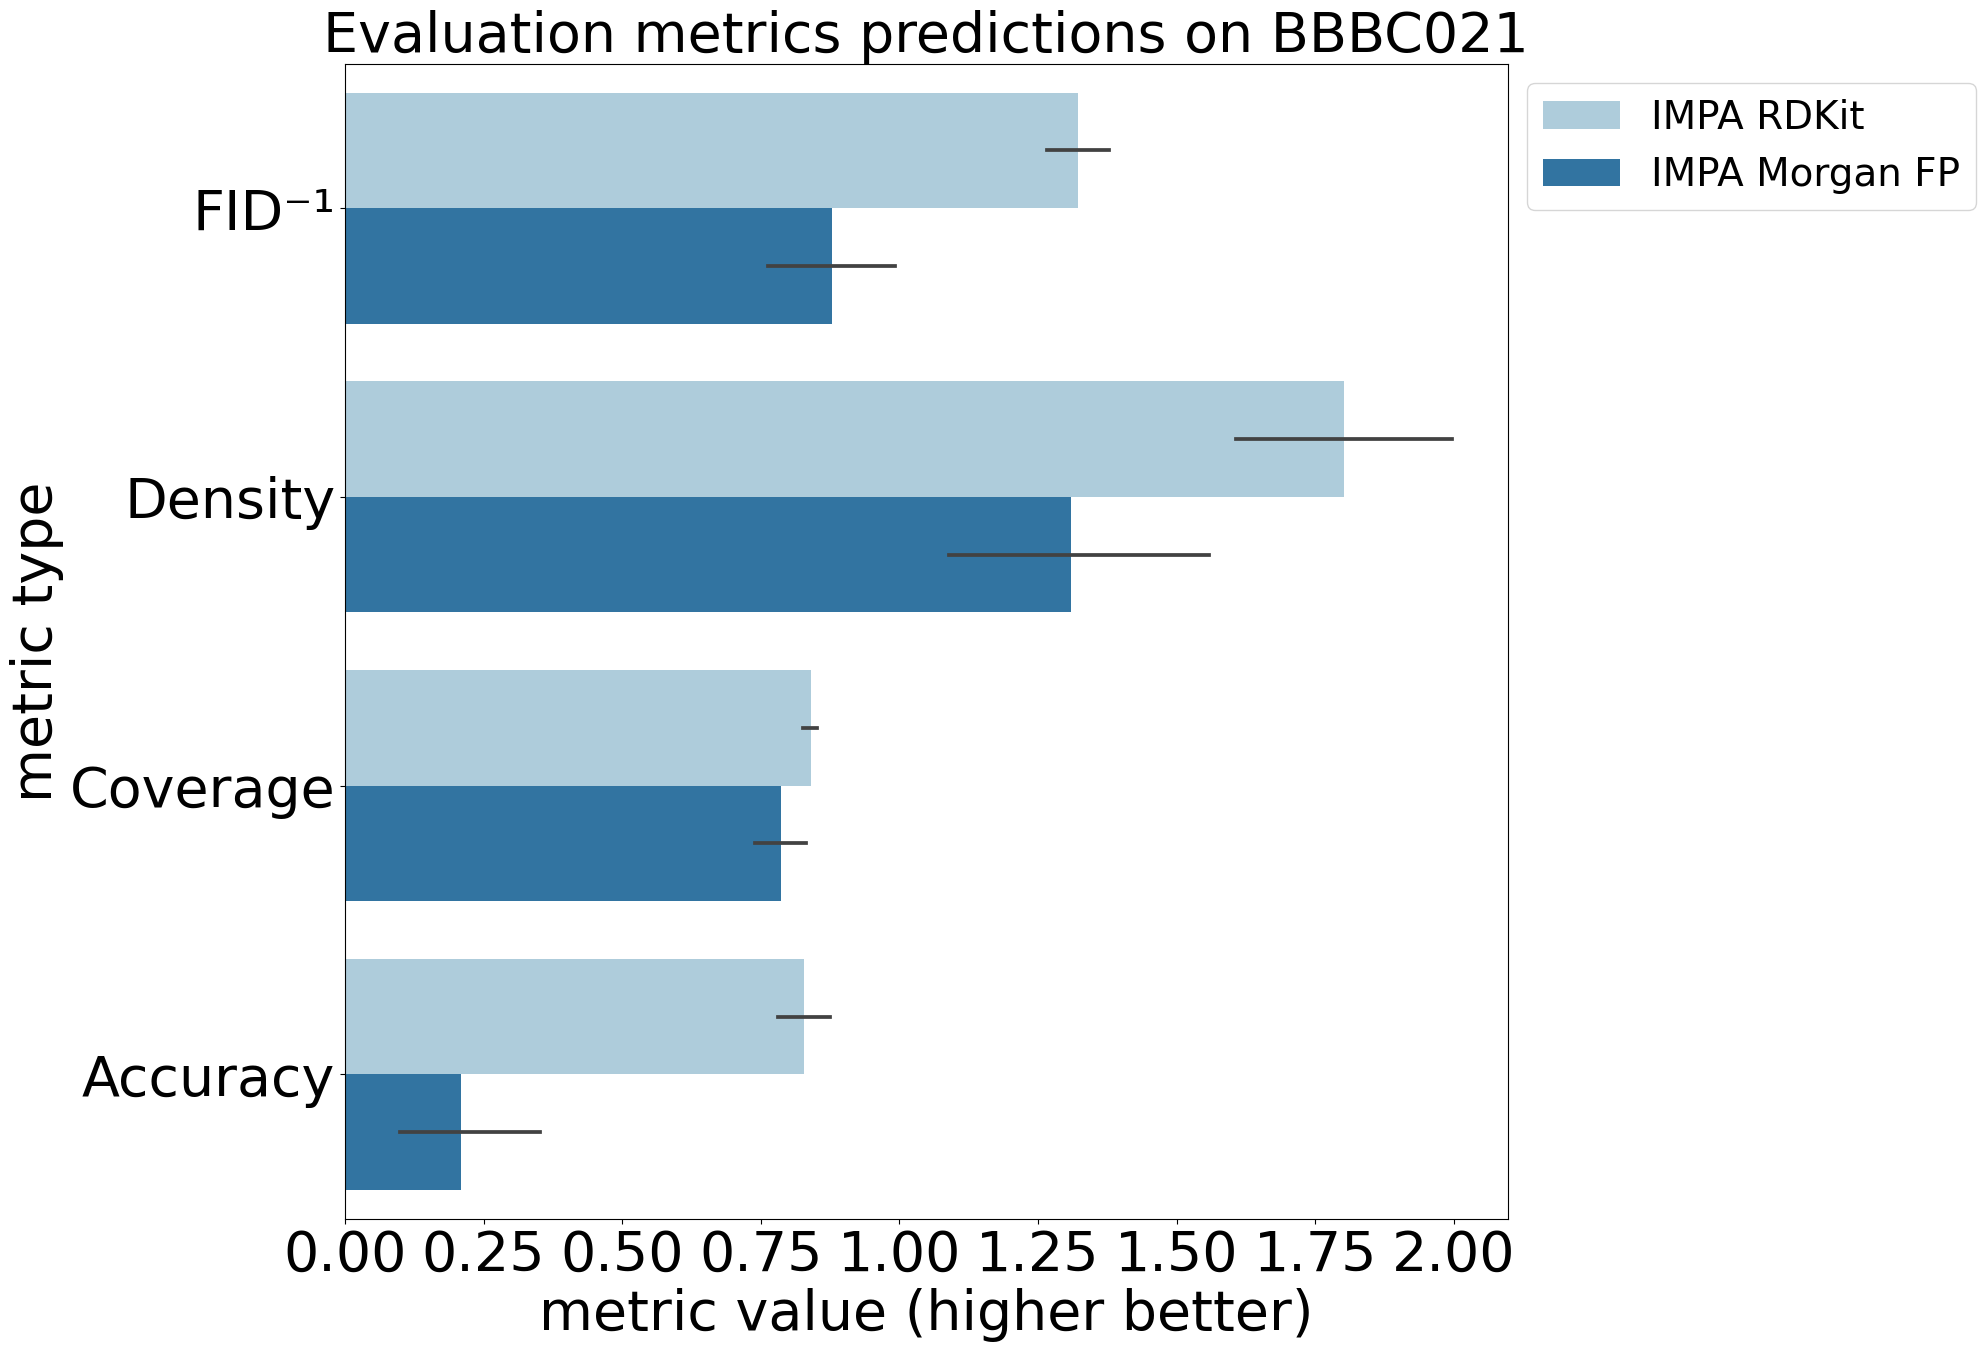

In [37]:
plot_results(fingerprint_comparison)

## COMPARE WITH STARGANV2

In [10]:
stargan_comparison = pd.concat([metric_IMPA_rdkit, metrics_starGANv2])

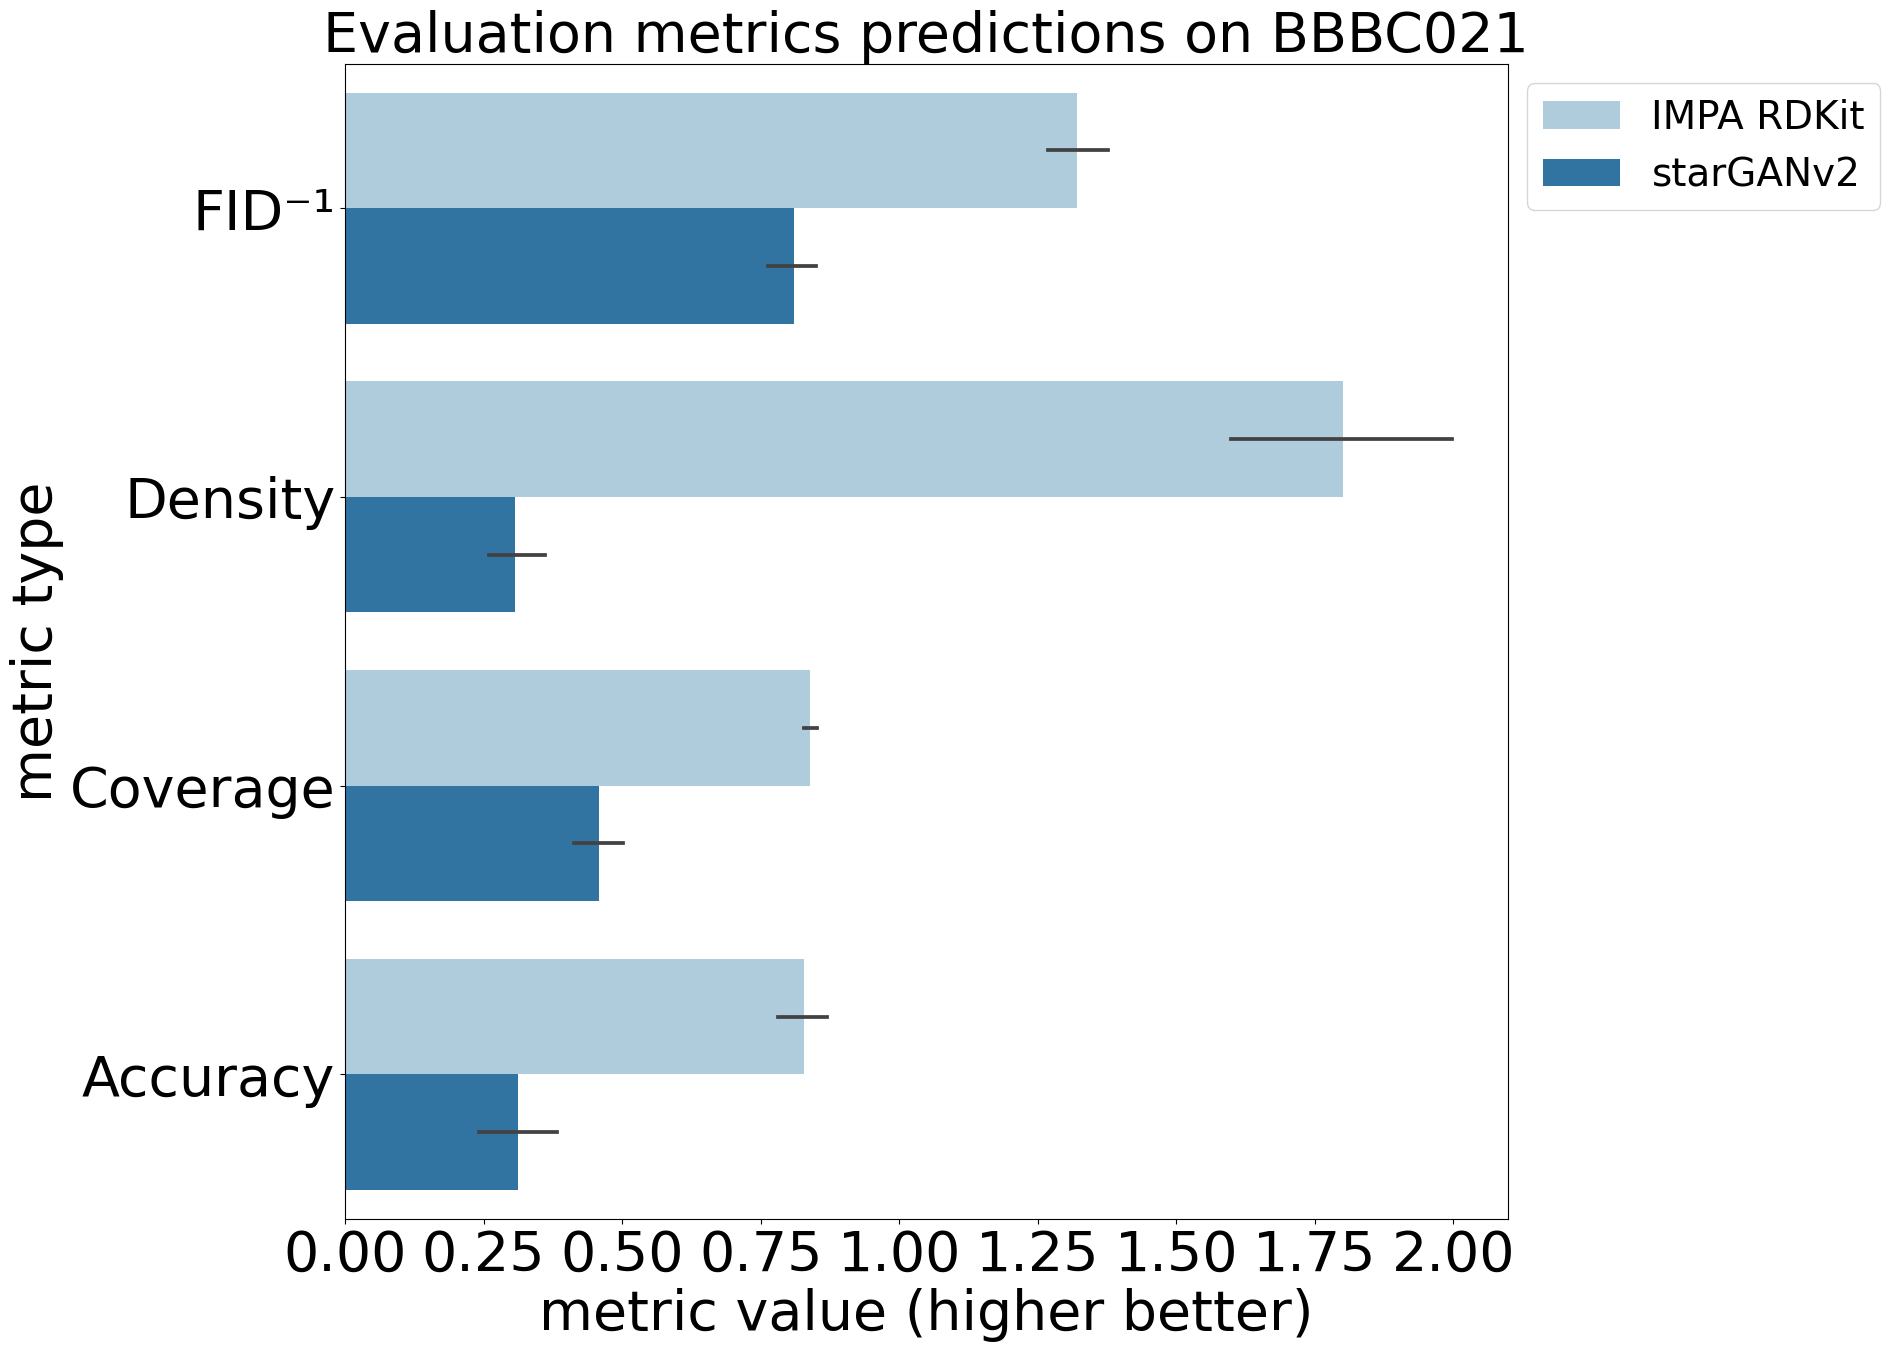

In [10]:
plot_results(stargan_comparison)

## Old plot including StarGANv2

In [182]:
def process_score(df, process_acc=True):
    df.loc[df['score_type']=='FID', 'score'] = 1 / df.loc[df['score_type']=='FID', 'score']
    df.loc[df['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'
    if process_acc:
        df.loc[df['score_type']=='accuracy', 'score'] = 1 -  df.loc[df['score_type']=='accuracy', 'score']
    return df

In [183]:
results_impa = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/IMPA/bbbc021_try.pkl')
results_impa['dataset'] = 'IMPA'
results_stargan = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/starGANv1/bbbc021_try.pkl')
results_stargan['dataset'] = 'StarGANv1'
results_stargan['model'] = 'StarGANv1'
results_starganv2 = pd.read_pickle('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_stargan_six2.pkl')
results_starganv2['dataset'] = 'StarGANv2'
results_starganv2['model'] = 'StarGANv2'
results_drit = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/DRIT++/bbbc021_try.pkl')
results_drit['dataset'] = 'DRIT++'
results_dmit = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/DMIT/bbbc021_try.pkl')
results_dmit['dataset'] = 'DMIT'
results_baseline = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/baseline/bbbc021_try.pkl')
results_baseline['dataset'] = 'baseline'

In [184]:
results_impa = results_impa.replace('Density', 'density')
results_impa = results_impa.replace('Coverage', 'coverage')
results_impa = results_impa.replace('1-Accuracy', 'accuracy')
results_impa = process_score(results_impa, process_acc=True)

results_stargan = results_stargan.replace('Density', 'density')
results_stargan = results_stargan.replace('Coverage', 'coverage')
results_stargan = results_stargan.replace('1-Accuracy', 'accuracy')
results_stargan = process_score(results_stargan, process_acc=True)

results_starganv2 = results_starganv2.replace('Density', 'density')
results_starganv2 = results_starganv2.replace('Coverage', 'coverage')
results_starganv2 = results_starganv2.replace('Accuracy', 'accuracy')
results_starganv2 = process_score(results_starganv2, process_acc=False)

results_drit = results_drit.replace('Density', 'density')
results_drit = results_drit.replace('Coverage', 'coverage')
results_drit = results_drit.replace('1-Accuracy', 'accuracy')
results_drit = process_score(results_drit, process_acc=True)

results_dmit = results_dmit.replace('Density', 'density')
results_dmit = results_dmit.replace('Coverage', 'coverage')
results_dmit = results_dmit.replace('1-Accuracy', 'accuracy')
results_dmit = process_score(results_dmit, process_acc=True)

results_baseline = results_baseline.replace('Density', 'density')
results_baseline = results_baseline.replace('Coverage', 'coverage')
results_baseline = results_baseline.replace('1-Accuracy', 'accuracy')
results_baseline = process_score(results_baseline, process_acc=True)

In [185]:
all_results = pd.concat([results_baseline, results_drit, results_dmit, results_stargan, results_starganv2, results_impa], axis=0)

In [186]:
grouping = all_results.groupby('model', as_index=False).mean()
grouping['score_type']='average'
grouping['mol'] = 'all'
grouping['dataset'] = grouping['model']


grouping

/tmp/ipykernel_1147868/1255228482.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouping = all_results.groupby('model', as_index=False).mean()


,model,score,run,score_type,mol,dataset
0,DMIT,0.853879,4.5,average,all,DMIT
1,DRIT++,0.700357,4.5,average,all,DRIT++
2,IMPA,1.131077,4.5,average,all,IMPA
3,StarGANv1,0.954527,4.5,average,all,StarGANv1
4,StarGANv2,0.993318,1.0,average,all,StarGANv2
5,baseline,0.669083,4.5,average,all,baseline


In [187]:
all_results=pd.concat([all_results, grouping])

In [188]:
all_results

,score,score_type,run,mol,model,dataset
0,1.309499,FID⁻¹,0.0,AZ138,baseline,baseline
1,0.662308,density,0.0,AZ138,baseline,baseline
2,0.703431,coverage,0.0,AZ138,baseline,baseline
3,0.828664,KNN,0.0,AZ138,baseline,baseline
4,0.021154,accuracy,0.0,AZ138,baseline,baseline
...,...,...,...,...,...,...
1,0.700357,average,4.5,all,DRIT++,DRIT++
2,1.131077,average,4.5,all,IMPA,IMPA
3,0.954527,average,4.5,all,StarGANv1,StarGANv1
4,0.993318,average,1.0,all,StarGANv2,StarGANv2


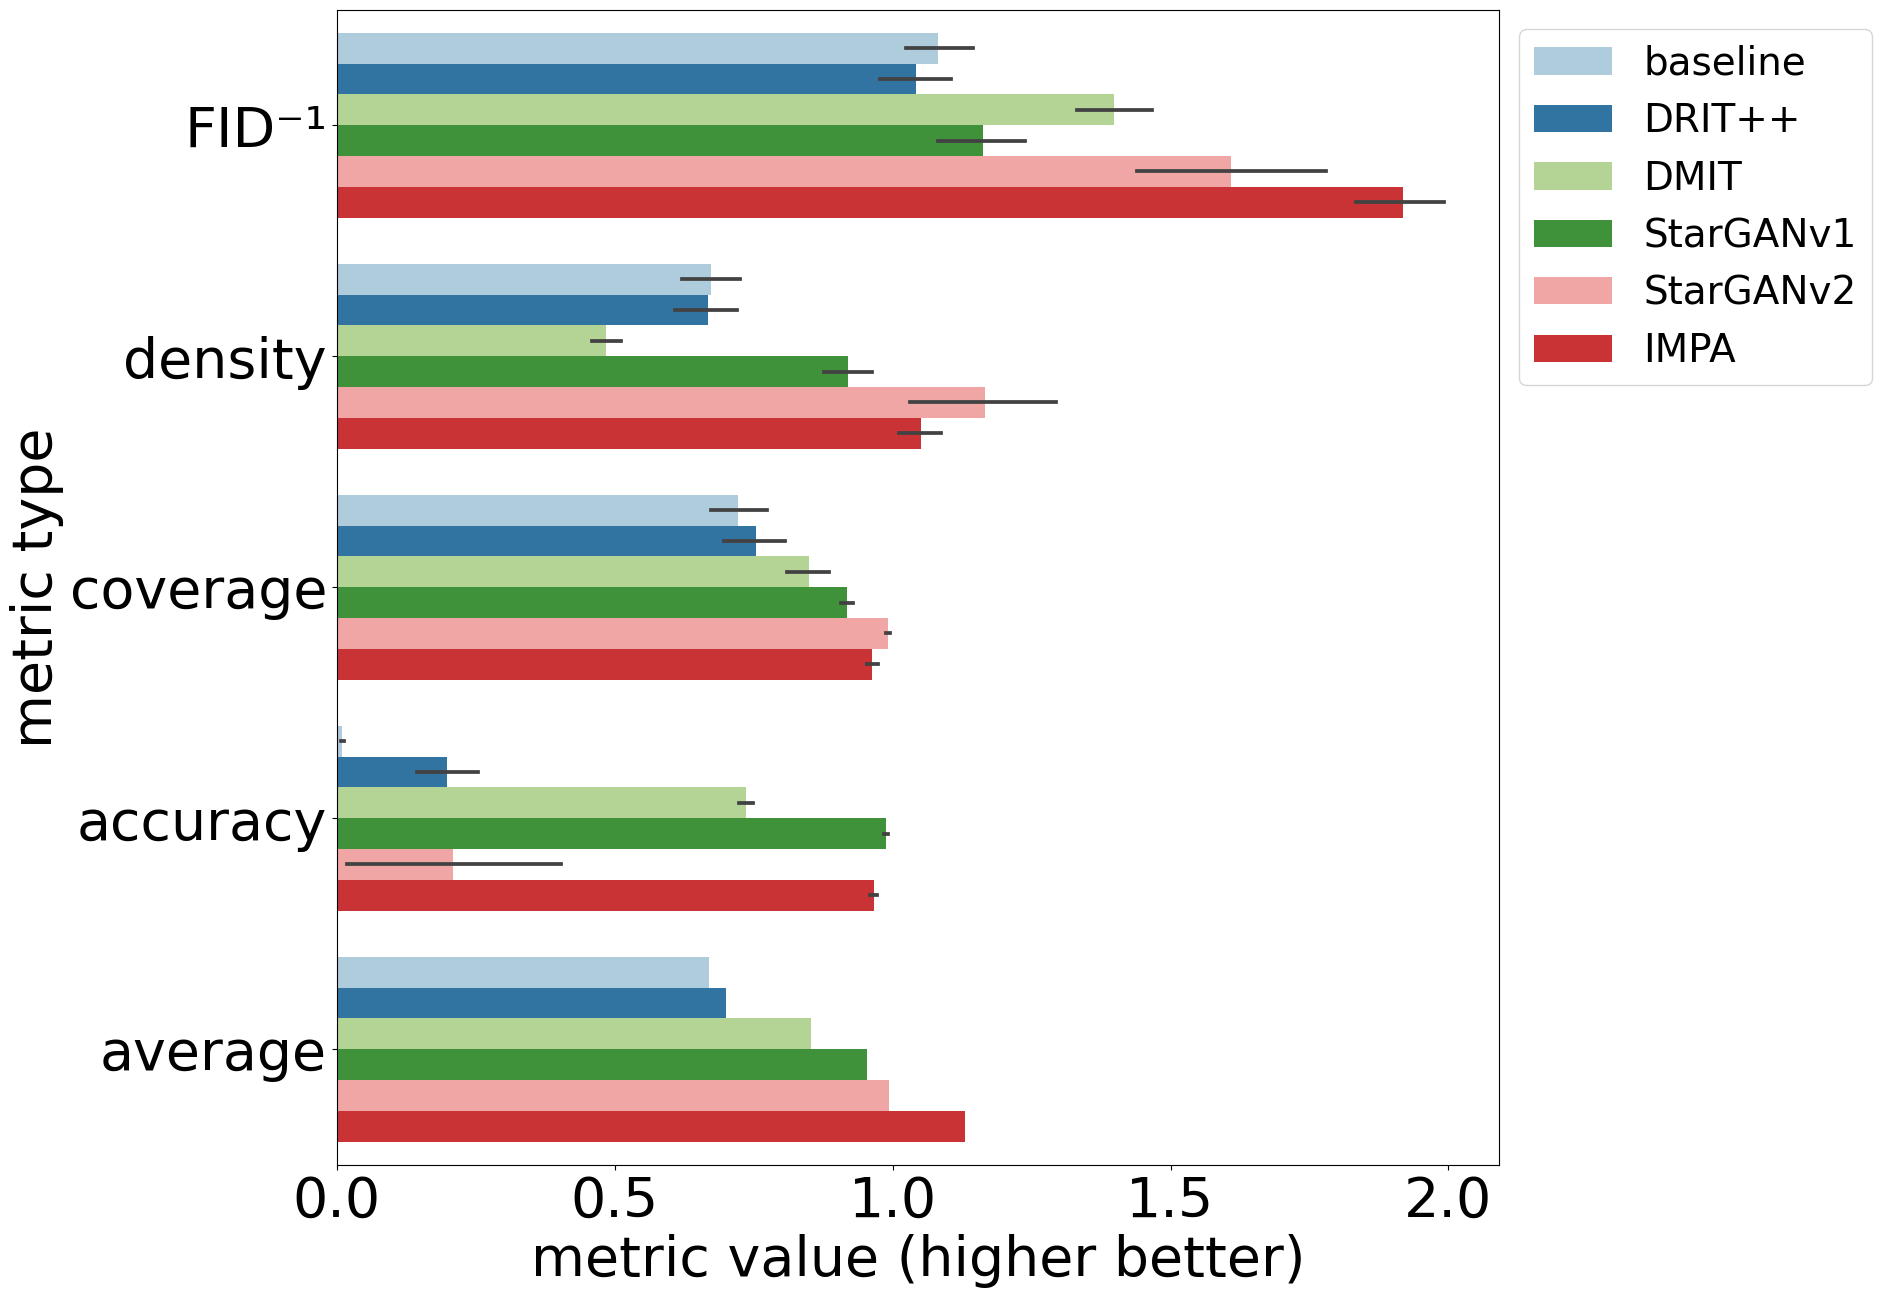

In [190]:
to_plot = ['FID\u207B\u00B9', 'density', 'coverage', 'accuracy', 'average']
# all_results = all_results.replace('baseline', 'Baseline')

plt.figure(figsize=(15,15))
ax = sns.barplot(data=all_results.loc[all_results.score_type.isin(to_plot)],
                x='score',
                y='score_type',
                hue='model',
                palette='Paired',
                orient='h')

plt.xticks([0, 0.5, 1, 1.5, 2], fontsize=40)
plt.yticks(fontsize=40)

# plt.xlabel('Metric value (\u2193)', fontsize=40)
plt.xlabel('metric value (higher better)', fontsize=40)
plt.ylabel('metric type', fontsize=40)
plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
plt.title('', fontsize=40)
plt.savefig('benchmark_scores_final.svg',
           dpi=300, bbox_inches='tight', format='svg')
plt.show()